# Project part 2 - Report

You have been asked to investigate transcriptomic differences between naive B cells of young and old mice to understand how resistance to infection may differ between the age groups. Your staff has performed a thorough computational analysis, which they've forwarded to you so that you can write the report describing your findings. Their results, and space for you to write your summary, are included below.

In [1]:
# import modules
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.stats
import pandas as pd
import sklearn
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from collections import Counter

In [2]:
# Load data
sc_meta = pd.read_csv('marrow_naive_B_meta.csv', index_col = 0)
sc_data = pd.read_csv('marrow_naive_B_exp.csv', index_col = 0)
sc_meta.head()

,cell_ontology_class,mouse.id,sex,age
cell,,,,
A10_B002327,naive B cell,24_59_M,male,24m
A11_B002327,naive B cell,24_59_M,male,24m
A13_B002327,naive B cell,24_59_M,male,24m
A15_B002327,naive B cell,24_59_M,male,24m
A17_B002327,naive B cell,24_59_M,male,24m


## Data preparation

In [3]:
Counter(sc_meta.age), Counter(sc_meta.sex), Counter(sc_meta.cell_ontology_class)

(Counter({'24m': 784, '3m': 401}),
 Counter({'male': 1185}),
 Counter({'naive B cell': 1185}))

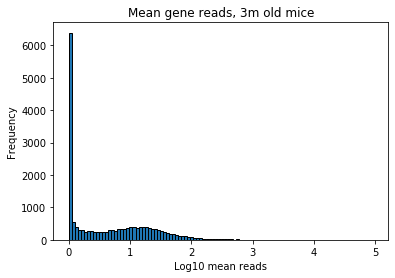

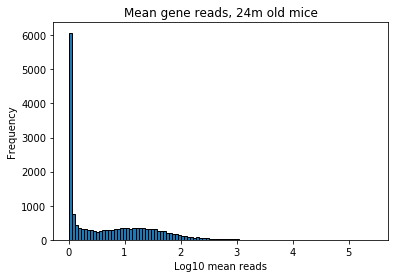

In [4]:
plt.hist(np.log10(np.mean(sc_data.loc[:,sc_meta.age == '3m'], axis = 1)+1), bins = 100)
plt.xlabel('Log10 mean reads')
plt.ylabel('Frequency')
plt.title('Mean gene reads, 3m old mice')
plt.show()
plt.hist(np.log10(np.mean(sc_data.loc[:,sc_meta.age == '24m'], axis = 1)+1), bins = 100)
plt.xlabel('Log10 mean reads')
plt.ylabel('Frequency')
plt.title('Mean gene reads, 24m old mice')
plt.show()

In [5]:
genes_to_keep = (np.log10(np.mean(sc_data.loc[:,sc_meta.age == '3m'], axis = 1)+1) > 1) | (np.log10(np.mean(sc_data.loc[:,sc_meta.age == '24m'], axis = 1)+1) > 1)
exp_sub = sc_data.loc[genes_to_keep,:]

sc_total_med = exp_sub.sum().median()
sc_data_norm = exp_sub / exp_sub.sum() * sc_total_med

### Explain what pre-processing steps or checks were used and why:

We first looked at our metadata to see what variables we have available to us. Having found age, cell type, and gender, we checked the distributions of these quantities to see whether they are possible confounders. (Note: we could've looked at individual also.) This revealed that we have cells from two age groups--mice which are aged 3 months and 24 months, respectively. The other considered covariates, meanwhile, only have one value, so we needn't worry about them.

We next looked at histograms of log10 reads for genes from cells in the two age groups to get a sense of how many genes will be useful for our analysis. In both cases, we see many lowly expressed genes as is the norm for scRNA-seq studies. To reduce our data to a manageable size, we've decided to only keep genes which average at least 10 reads in one of the age groups. This choice is partially informed by the shape of the histograms themsevles. 

Having reduced our data to a subset of core genes, we then normalized the reads using TC normalization. Cells were rescaled such that their total number of reads matched the median total reads of the original, unnormalized cells. We used this normalization because the median is too unstable in scRNA-seq due to its sparsity.

## Exploratory data analysis

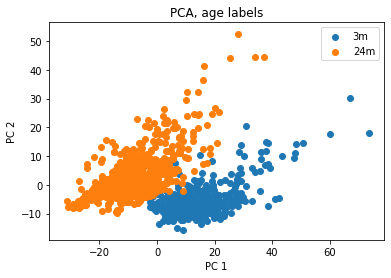

In [6]:
# EDA
x = StandardScaler().fit_transform(np.log2(sc_data_norm.T+1))
pca = PCA(n_components = 100)
principalComponents = pca.fit_transform(x)

plt.scatter(principalComponents[sc_meta['age'] == '3m',0], principalComponents[sc_meta['age'] == '3m',1])
plt.scatter(principalComponents[sc_meta['age'] == '24m',0], principalComponents[sc_meta['age'] == '24m',1])
plt.legend(['3m', '24m'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, age labels')
plt.show()

In [7]:
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)

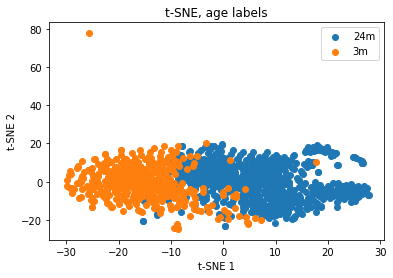

In [8]:
ages = np.unique(sc_meta['age'])
for x in ages:
    plt.scatter(X_embedded[sc_meta['age'] == x,0], X_embedded[sc_meta['age'] == x,1])
plt.legend(ages)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, age labels')
plt.show()

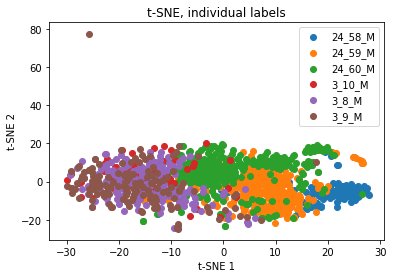

In [9]:
indivs = np.unique(sc_meta['mouse.id'])
for x in indivs:
    plt.scatter(X_embedded[sc_meta['mouse.id'] == x,0], X_embedded[sc_meta['mouse.id'] == x,1])
plt.legend(indivs, bbox_to_anchor = (1,1))
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, individual labels')
plt.show()

### Interpret the exploratory results from dimension reduction:

Here we've first performed PCA and followed up with t-SNE. Both reveal a pattern in which cells co-localize by age group, although they still comprise one large cluster. Coloring the plot by the mouse of origin shows that young mice are indistinguishable using t-SNE whereas the cells from the older mice group by mouse. This may suggest greater inter-individual heterogeneity of gene expression asssociated with age. Such behavior could indicate the loss of regulatory function or senescence. 

## Differential expression

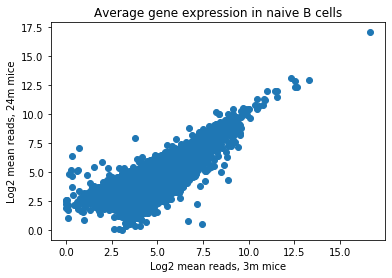

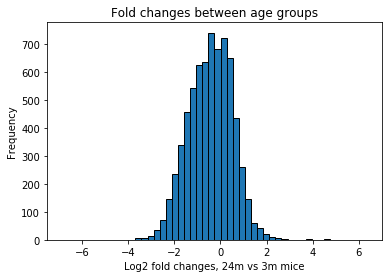

In [16]:
# Differential expression, GO
young_mice = sc_meta['age'] == '3m'
old_mice = sc_meta['age'] == '24m'

young_exp = sc_data_norm.loc[:, young_mice]
old_exp = sc_data_norm.loc[:, old_mice]

plt.scatter(np.log2(np.mean(young_exp, axis = 1)+1), np.log2(np.mean(old_exp, axis = 1)+1))
plt.xlabel('Log2 mean reads, 3m mice')
plt.ylabel('Log2 mean reads, 24m mice')
plt.title('Average gene expression in naive B cells')
plt.show()

log2_fcs = np.log2(np.mean(old_exp, axis = 1)+1) - np.log2(np.mean(young_exp, axis = 1)+1)
plt.hist(log2_fcs, bins = 50)
plt.xlabel('Log2 fold changes, 24m vs 3m mice')
plt.ylabel('Frequency')
plt.title('Fold changes between age groups')
plt.show()

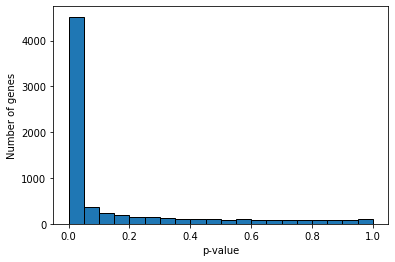

4309

In [11]:
gene_p_vals = []
for x in np.arange(sc_data_norm.shape[0]):
    p_val = scipy.stats.mannwhitneyu(young_exp.iloc[x,:], old_exp.iloc[x,:], alternative = 'two-sided')[1]
    gene_p_vals.append(p_val)
    
plt.hist(gene_p_vals, bins = 20)
plt.xlabel('p-value')
plt.ylabel('Number of genes')
plt.title('')
plt.show()

# Compute the number of genes which are differentially expressed (p-value less than or equal to 0.05)
q_vector = stats.multitest.multipletests(gene_p_vals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
n_de = sum(q_vector <= 0.05)
n_de

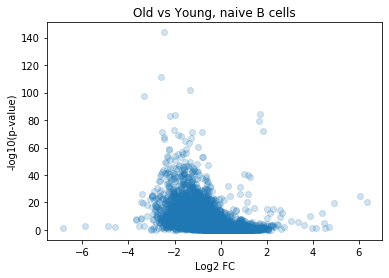

In [12]:
log_p_vals = -np.log10(gene_p_vals)

plt.scatter(log2_fcs, log_p_vals, alpha=0.2)
plt.xlabel('Log2 FC')
plt.ylabel('-log10(p-value)')
plt.title('Old vs Young, naive B cells')
plt.show()

### Summarize the outcome of your differential expression testing:

Using rank-sum tests, we performed a differential expression analysis on all of the retained genes by comparing cells from 3-month-old mice to 24-month-old mice. In total, we found 4309 which met our threshold of a q-value of 0.05, a large fraction of the genes we considered. Our scatterplot, p-value histogram, and volcano plot all demonstrate that many of the genes which were differentially expressed were underexpressed in the old mice, perhaps suggesting that B cells in older mice are less active than those in younger mice. This is in contrast to what we often find when comparing distinct cell types, where roughly the same number of genes tend to be overexpressed as underexpressed. In this case, our observation is consistent with the fact that immune systems become less effective as organisms age. 

## Conclusion

### What do you conclude about whether there is a difference in ages? If there is any, how would you describe it?

Yes, there does seem to be a difference in ages. This is revealed by our exploratory analyses (PCA/t-SNE) as well as our differential expression analysis. It appears that a subset of genes are expressed at lower levels in the naive B cells of older mice, possibly associated with decreased function. This is clearly demonstrated by our volcano plot. One caveat is that our normalization may have artificially made genes look more lowly expressed if older cells had a gene which increased greatly in its expressed. Such a possiblity should be ruled out before making any final, definitive claims. This is called composition bias. A gene ontology enrichment analysis should be performed to understand whether any specific processes or functions of naive B cells are affected by the group of genes we've identified.

# Submit

In [13]:
#from client.api.notebook import Notebook

In [14]:
# ok = Notebook('Project02_Report.ok')
# _ = ok.auth(inline=True)

In [15]:
# Submit the assignment.
#_ = ok.submit()